In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import scipy 
import os
import unittest
import seaborn as sns

In [4]:
df_battery = pd.read_csv('../data/Battery_Dataset.csv')

In [5]:
import csv
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold 
import math

import sklearn
import statistics as stcs
import scipy.stats as stats


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV       
from sklearn import linear_model, datasets
from sklearn.utils import resample
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error

In [6]:
#One hot encoding (alphebetical order)
ohe = OneHotEncoder()
ACE = df_battery.loc[:,['anode','cathode','electrolyte']]
ACE = ohe.fit_transform(ACE)
ACE = pd.DataFrame(ACE.toarray())

ACE_col_name = ['A1','C1','C2','C3','E1','E2','E3']
for i in range(len(ACE.columns)):
    ACE = ACE.rename({ACE.columns[i]: ACE_col_name[i]}, axis=1) 
    
df_battery = pd.concat([ACE, df_battery],axis=1)

In [7]:
data = df_battery

np.random.seed(66)
def data_split (data, test_ratio):
    
    total_row = df_battery.shape[0]
    test_row = round(total_row *test_ratio)
    train_row = total_row - test_row
    
    indices =np.random.permutation(total_row)
    train_indx, test_idx =indices[:train_row], indices[train_row:]
    train,test = df_battery.iloc[train_indx,:], df_battery.iloc[test_idx,:]

    X_test = test[['A1','C1','C2','C3','E1','E2','E3','Cycle','temperature','discharge_crate']]
#    y_test = test[['Charge_Capacity (Ah)']]
    y_test = test[['Discharge_Capacity (Ah)']]
#    y_test = test[['Charge_Energy (Wh)']]
#    y_test = test[['Discharge_Energy (Wh)']]
#    y_test = test[['Coulombic_Efficiency (%)']]
#    y_test = test[['Energy_Efficiency (%)']]
    X_train = train[['A1','C1','C2','C3','E1','E2','E3','Cycle','temperature','discharge_crate']]
#    y_train = train[['Charge_Capacity (Ah)']]
    y_train = train[['Discharge_Capacity (Ah)']]
#    y_train = train[['Charge_Energy (Wh)']]
#    y_train = train[['Discharge_Energy (Wh)']]
#    y_train = train[['Coulombic_Efficiency (%)']]
#    y_train = train[['Energy_Efficiency (%)']]
    return train,test,X_train,y_train,X_test,y_test
    
train,test,X_train,y_train,X_test,y_test = data_split(data,0.2)


In [8]:
# df = pd.DataFrame(data)
# df

In [9]:
kf = KFold(n_splits=10,random_state =66,shuffle= True)

In [10]:
#Tuning hyperparameters
rand_para = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

svm_model = DecisionTreeRegressor()
n_iteration = 200
Scoring = ['explained_variance','neg_mean_squared_error',"r2"]
random_search = RandomizedSearchCV(
    svm_model,
    param_distributions=rand_para,
    cv =5)
#     scoring=Scoring,
#     error_score=0,
#     random_state=66,
#     return_train_score=True,
#     n_jobs=-1,
#     n_iter=n_iteration,
#     verbose=10,
#     refit=False)



random_search.fit(X_train,y_train)

#y_predict=random_search.predict(X_test)
#math.sqrt(stcs.mean((y_predict-y_test)**2))

print('Best hyperparameters: ', random_search.best_params_)

/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1246, in fit
    X_idx_sorted=X_idx_sorted)
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 275, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estim

Best hyperparameters:  {'splitter': 'best', 'min_weight_fraction_leaf': 0.2, 'min_samples_leaf': 10, 'max_leaf_nodes': 60, 'max_features': None, 'max_depth': 11}


/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1246, in fit
    X_idx_sorted=X_idx_sorted)
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 275, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estim

In [11]:
#Tuning hyperparameters
rand_para = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

svm_model = DecisionTreeRegressor()
n_iteration = 200
Scoring = ['explained_variance','neg_mean_squared_error',"r2"]
random_search = RandomizedSearchCV(
    svm_model,
    param_distributions=rand_para,
    cv =5)
#     scoring=Scoring,
#     error_score=0,
#     random_state=66,
#     return_train_score=True,
#     n_jobs=-1,
#     n_iter=n_iteration,
#     verbose=10,
#     refit=False)



random_search.fit(X_train,y_train)

#y_predict=random_search.predict(X_test)
#math.sqrt(stcs.mean((y_predict-y_test)**2))

print('Best hyperparameters: ', random_search.best_params_)

Best hyperparameters:  {'splitter': 'random', 'min_weight_fraction_leaf': 0.3, 'min_samples_leaf': 10, 'max_leaf_nodes': 50, 'max_features': None, 'max_depth': 5}


/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1246, in fit
    X_idx_sorted=X_idx_sorted)
  File "/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 275, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight_fraction_leaf must in [0, 0.5]

  FitFailedWarning)
/home/roselee3/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estim

In [12]:
#Train-error
np.random.seed(66)

DT_model_train = DecisionTreeRegressor(random_state = 66)

train_results =[]
train_results_name =['Experimental','Predicted ','RMSE']


for train_index, test_index in kf.split(X_train):
    #print("Train:", train_index, "Validation:", test_index)
    X_training, X_validate = X_train.iloc[train_index], X_train.iloc[test_index]
    y_training, y_validate = y_train.iloc[train_index], y_train.iloc[test_index]
    
    np.random.seed(66)
    DT_model_train .fit(X_training,y_training)
    y_train_predicted = DT_model_train.predict(X_validate)
    number_validate =X_validate.shape[0]
    #print(y_train_predicted.shape)
    mse = mean_squared_error(y_train_predicted, y_validate)
    RMSE = np.sqrt(mse)
    #squared_deviations=(y_train_predicted.reshape(-1,1)-y_validate)**2
    #RMSE=math.sqrt(squared_deviations.sum()/number_validate)
    #RMSE = math.sqrt(stcs.mean((y_train_predicted-y_validate)**2))
    train_results.append([y_validate,y_train_predicted,RMSE])

In [13]:
Train_results =pd.DataFrame (train_results,columns=train_results_name)
np.average(Train_results['RMSE'])

0.6783593255787642

In [14]:
#Test-set Validation
DecisionTree_model =DecisionTreeRegressor(random_state = 66)

np.random.seed(66)
DecisionTree_model.fit(X_train,y_train)
y_predict=DecisionTree_model.predict(X_test)
#print(y_predict)

In [15]:
number_test = X_test.shape[0]
mse = mean_squared_error(y_predict, y_test)
RMSE = np.sqrt(mse)
RMSE
# squared_deviations=(y_predict.reshape(-1,1)-y_test)**2
# math.sqrt(squared_deviations.sum()/number_test)

0.7433258717161

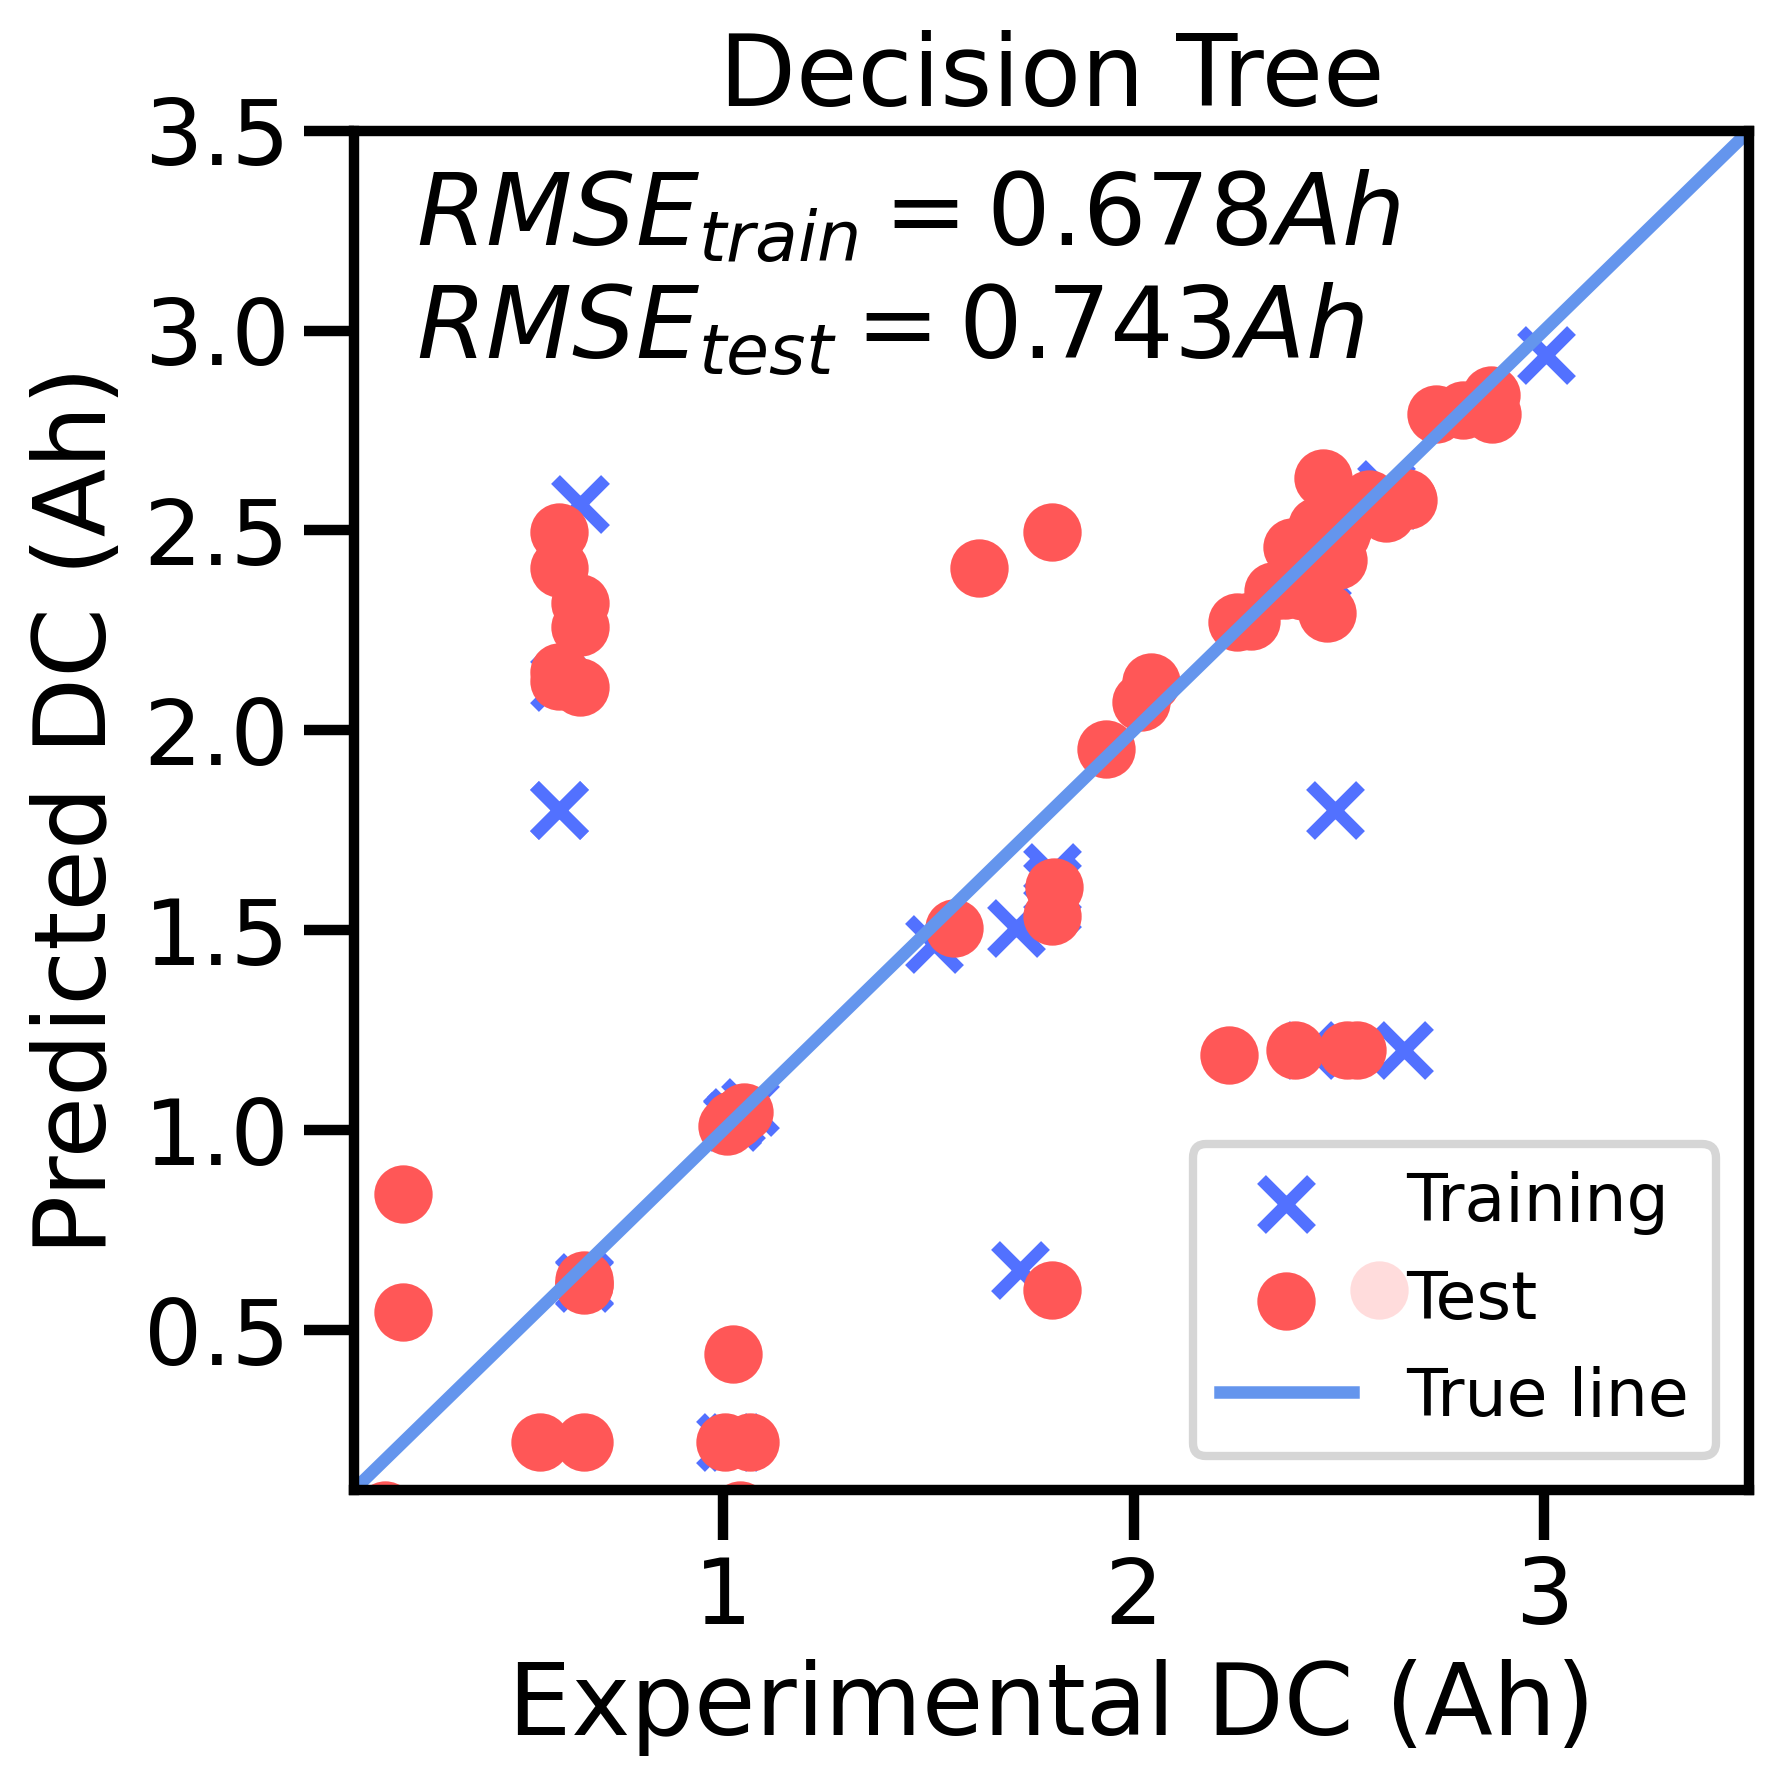

In [23]:
sns.set_context('poster')
figure(figsize=(6, 6), dpi=300)

plt.axis([0.1,3.5,0.1,3.5])
plt.scatter(x = y_validate, y = y_train_predicted, marker = 'x', c='#5271FF',label='Training')
plt.scatter(x = y_test, y = y_predict, c='#FF5757',label='Test')
plt.plot([0,5],[0,5],label ='True line',c='cornflowerblue')
plt.legend(loc='lower right', fontsize = 16)
plt.title(label='Decision Tree')

plt.xlabel(r'Experimental DC (Ah)')
plt.ylabel(r'Predicted DC (Ah)')
plt.text(0.25, 2.65, r'$RMSE_{train}=0.678Ah$'+'\n'+r'$RMSE_{test}=0.743Ah$' +"\n")
#plt.savefig('DecissionTrees-Predicted-vs-test.png',dpi=600)
plt.show()